# Usage as a library

This guide introduces basic concepts needed for using PyQBench as a library from a Python
script. In particular, we will cover the following topics:

- Defining experiment using circuit components.
- Assembling circuits needed for given benchmarking scheme.
- Running experiment on simulator or hardware.
- Obtaining empirical probability of successful discrimination between measurements.

## Setting the stage

Before we start, make sure you installed PyQBench (see installation for 
detailed instructions).
Optionally, you might want to install matplotlib library for plotting the final results.

In this guide we won't repeat mathematical foundations needed for understanding measurement
discrimination experiments. We'll only restrict ourselves to the details necessary for running 
experiments using PyQBench. However, we encourage you to check out {ref}`section/math` to
get a better grasp of the entities and concepts discussed here.

## What do we need?

On the conceptual level, every discrimination experiment performed in PyQBench needs the following:

- Discriminator, i.e. optimal initial state for the circuit.
- Unitary $U^\dagger$ defining alternative measurement to be discriminated from the measurement
  in Z-basis.
- $V_0^\dagger$ and $V_1^\dagger$, positive and negative parts of optimal 
  measurement from Holevo-Helstrom theorem.

Currently available quantum computers typically cannot start execution from an arbitrary state. 
Instead, we have to prepare it ourselves. Hence, to execute experiment using postselection 
scheme, we need the following operations implemented as Qiskit Instructions:

- An instruction taking $|00\rangle$ to the desired discriminator.
- Instructions implementing $U^\dagger$, $V_0^\dagger$ and $V_1^\dagger$.

Task of implementing needed instruction is trivial when we know the decomposition of our 
unitaries into sequences of gates. If we only know the unitary matrices, we can either decompose 
them by hand, or try using one of the available transpilers.

For the direct-sum experiment we don't use $V_0^\dagger$ and $V_1^\dagger$ separately. Instead, 
we need a two-qubit gate $V_0^\dagger \oplus V_1^\dagger$.

## Our toy model

In our example, we will use $U = H$ (the Hadamard gate). To keep us focused on the implementation
in PyQBench and not delve too deep into mathematical explanation, we simply provide explicit 
formulas for discriminator $|\Psi_0\rangle$ and $V_0$ and $V_1$, leaving the 
calculations to the interested reader.

The explicit formula for discriminator in our toy model reads:

$$
| \Psi_0 \rangle = \frac{1}{\sqrt{2}} (| 00 \rangle + | 11 \rangle),
$$ 

with corresponding parts of optimal measurement being equal to 

$$
V_0 = \begin{bmatrix}
\alpha & -\beta \\
\beta & \alpha
\end{bmatrix}
\quad
V_1 = \begin{bmatrix}
-\beta & \alpha \\
\alpha & \beta
\end{bmatrix}
$$

where

$$
\alpha = \frac{\sqrt{2 - \sqrt{2}}}{2} = \cos\left(\frac{3}{8}\pi\right)
$$

$$
\beta = \frac{\sqrt{2 + \sqrt{2}}}{2} = \sin\left(\frac{3}{8}\pi\right)
$$

For completeness, here's how the direct sum $V_0 \oplus V_1$ looks like

$$
V_0 \oplus V_1  = \begin{bmatrix}
V_0 & 0 \\
0 & V_1
\end{bmatrix} = \begin{bmatrix}
\alpha & -\beta & 0 & 0 \\
\beta & \alpha & 0 & 0 \\
0 & 0 & -\beta & \alpha \\
0 & 0 & \alpha & \beta
\end{bmatrix}
$$

As a next step, we need decompose our matrices into actual sequences of gates.

## Decomposing circuit components into gates

We are lucky, because our discriminator is just a Bell state. Thus, the circuit taking 
$|00\rangle$ to $|\Psi_0 \rangle$ is well known, and comprises  Hadamard gate 
followed by CNOT gate on both qubits.

< PLACEHOLDER FOR CIRCUIT >

For $V_0$ and $V_1$ observe that $V_0 = \operatorname{RY} \left( \frac{3}{4} \pi \right)$, where 
$\operatorname{RY}$ is just standard rotation around the $Y$ axis

$$
\operatorname{RY}(\theta) = \begin{bmatrix}
\cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \\
\sin \frac{\theta}{2} & \cos \frac{\theta}{2}
\end{bmatrix}
$$

To obtain $V_1$, we need only to swap the columns, which is equivalent to following $V_0$ by $X$ 
matrix. Finally, remembering that we need to take Hermitian conjugates for our actual circuits,
we obtain the following decompositions

$$
V_0^\dagger = \operatorname{RY} \left( \frac{3}{4} \pi \right)^\dagger = \operatorname{RY} \left
( -\frac{3}{4} \pi \right)
$$

$$
V_1^\dagger = \left(\operatorname{RY} \left( \frac{3}{4} \pi \right) \cdot X\right)^\dagger = 
X \cdot \operatorname{RY} \left ( -\frac{3}{4} \pi \right)
$$

Recall that to perform an experiment using postselection scheme we need four circuits. One of them 
(realizing $(U, V_0)$ alternative) looks like this.

![Circuit implementing U^dagger, V_0 alternative](../img/hadamard_u_v0.svg){#imgattr width="70%"}

Other circuits can be created analogously by using identity instead of $U$ and/or $V_1^\dagger$ 
instead of $V_0^\dagger$. However, you don't need to memorize how the circuits look like, because
qbench will construct them for you.

## Defining needed instructions using Qiskit

We will start our code with the needed imports. Aside standard stuff like 
numpy, we need to be able to define quantum circuits and a simulator to run 
them.

In [1]:
from qiskit import QuantumCircuit, Aer
import numpy as np

Next we import needed functions from PyQBench. For our first example we'll 
need two functions.

In [2]:
from qbench.schemes.postselection import benchmark_using_postselection
from qbench.schemes.direct_sum import benchmark_using_direct_sum

The first one, {meth}`~qbench.schemes.postselection.benchmark_using_postselection` performs 
the whole benchmarking process using postselection scheme. In particular, it 
assembles the needed circuits, runs them using specified backend and 
interprets measurement histograms in terms of discrimination probability. 
Similarly, the {meth}`~qbench.schemes.direct_sum.benchmark_using_direct_sum` 
does the same but with "direct sum" scheme.

To run any of these functions, we need to define components that we 
discussed in previous sections. Its perhaps best to do this by defining 
separate function for each component. The important thing to remember is 
that we need to create Qiskit instructions, not circuits. We can 
conveniently do so by constructing circuit acting on qubits 0 and 1 and then 
converting them using [to_instruction()](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.to_instruction.html)` method.


In [4]:
def state_prep():
    circuit = QuantumCircuit(2)
    circuit.h(0)
    circuit.cnot(0, 1)
    return circuit.to_instruction()


def u_dag():
    circuit = QuantumCircuit(1)
    circuit.h(0)
    return circuit.to_instruction()


def v0_dag():
    circuit = QuantumCircuit(1)
    circuit.ry(-np.pi * 3 / 4, 0)
    return circuit.to_instruction()


def v1_dag():
    circuit = QuantumCircuit(1)
    circuit.ry(-np.pi * 3 / 4, 0)
    circuit.x(0)
    return circuit.to_instruction()


def v0_v1_direct_sum_dag():
    circuit = QuantumCircuit(2)
    circuit.ry(-np.pi * 3 / 4, 0)
    circuit.cnot(0, 1)
    return circuit.to_instruction()

:::{note}
You may wonder why we only define circuits on qubits 0 and 1, when we might 
want to run the benchmarks for other qubits as well? It turns out that it 
doesn't matter. In Qiskit, circuit converted to Instruction behaves just 
like a gate. During the assembly stage, PyQBench will use those 
instructions on correct qubits.
:::

## Running simulations in the simplest scenario

Lastly, before launching our simulations, we need to construct simulator 
they will run on. For the purpose of this example, we'll start with basic 
[Qiskit Aer simulator](https://github.com/Qiskit/qiskit-aer).

In [5]:
simulator = Aer.get_backend("aer_simulator")

Now running the simulation is as simple as invoking functions imported from 
`qbench` package.

In [6]:
postselection_result = benchmark_using_postselection(
    backend=simulator,
    target=0,
    ancilla=1,
    state_preparation=state_prep(),
    u_dag=u_dag(),
    v0_dag=v0_dag(),
    v1_dag=v1_dag(),
    num_shots_per_measurement=10000,
)

In [8]:
direct_sum_result = benchmark_using_direct_sum(
    backend=simulator,
    target=1,
    ancilla=2,
    state_preparation=state_prep(),
    u_dag=u_dag(),
    v0_v1_direct_sum_dag=v0_v1_direct_sum_dag(),
    num_shots_per_measurement=10000,
)

In [12]:
p_succ = (2 + np.sqrt(2)) / 4
print(f"Real p_succ = {p_succ}")
print(
    f"Postselection: p_succ = {postselection_result}, abs. error = {p_succ - postselection_result}"
)
print(f"Direct sum: p_succ = {direct_sum_result}, abs. error = {p_succ - direct_sum_result}")

Real p_succ = 0.8535533905932737
Postselection: p_succ = 0.8542241847738258, abs. error = -0.0006707941805520479
Direct sum: p_succ = 0.8536, abs. error = -4.6609406726294544e-05


## Gaining more control  over the benchmarking process
In the example presented above we used functions that automate the whole process - from the circuit assembly, through running the simulations to interpreting the results. But what if we want more control over some parts of this process? Maybe we want play around with some models? Or maybe we want to run the same experiment on multiple backends and we don't want them to be assembled over and over again?

From our (i.e. the developers of PyQBench) perspective, one possibility would be to add more and more parameters to `benchmark_using_xyz` functions, but this approach clearly is not very scalable. Also, there is no way we can anticipate all the possible use cases!

We decided on another approach. PyQBench provides functions performing:

- assembly of circuits needed for experiment, provided the components discussed above
- interpretation of the obtained measurements

When using these functions, you need to take care of running circuits on some backend yourself, but it gives you unlimited power over the whole process. The difference between the two approaches is illustrated on the diagrams below.

In [29]:
import iplantuml

Writing output for /home/dexter/Projects/iitis/PyQBench/docs/source/notebooks/cee7e7f7-817f-4e86-a60b-d0d1bf48419f.uml to cee7e7f7-817f-4e86-a60b-d0d1bf48419f.svg


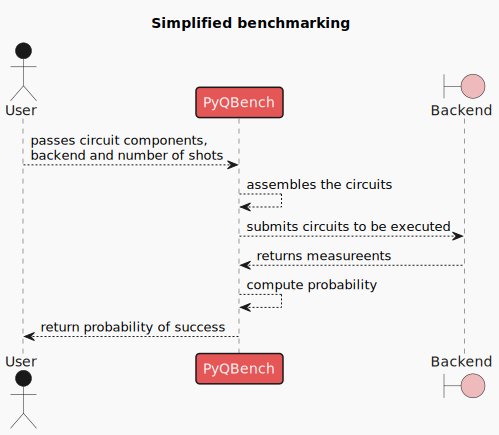

In [27]:
%%plantuml
@startuml
!theme mars
title Simplified benchmarking
actor User
participant PyQBench
boundary Backend

User --> PyQBench: passes circuit components,\nbackend and number of shots
PyQBench --> PyQBench: assembles the circuits
PyQBench --> Backend: submits circuits to be executed
Backend --> PyQBench: returns measurements
PyQBench --> PyQBench: compute probability
PyQBench --> User: return probability of success
@enduml


Writing output for /home/dexter/Projects/iitis/PyQBench/docs/source/notebooks/3dee3601-2949-4408-a48e-8a3ab89072da.uml to 3dee3601-2949-4408-a48e-8a3ab89072da.svg


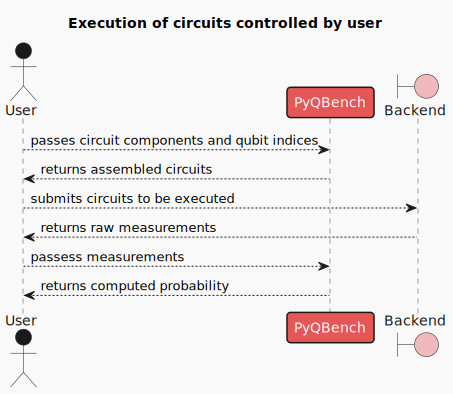

In [28]:
%%plantuml
@startuml
!theme mars
title Execution of circuits controlled by user
actor User
participant PyQBench
boundary Backend

User --> PyQBench: passes circuit components and qubit indices
PyQBench --> User: returns assembled circuits
User --> Backend: submits circuits to be executed
Backend --> User: returns raw measurements
User --> PyQBench: passess measurements
PyQBench --> User: returns computed probability
@enduml


### Assembling circuits
Let us focus only on the postselection case, as the direct sum case is analogous. First, we need to import two more functions from PyQBench.

In [30]:
from qbench.schemes.postselection import (
    assemble_postselection_circuits,
    compute_probabilities_from_postselection_measurements,
)

In [33]:
circuits = assemble_postselection_circuits(
    target=0,
    ancilla=1,
    state_preparation=state_prep(),
    u_dag=u_dag(),
    v0_dag=v0_dag(),
    v1_dag=v1_dag(),
)

circuits

{'id_v0': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fd505feda00>,
 'id_v1': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fd505fc2730>,
 'u_v0': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fd514d39eb0>,
 'u_v1': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fd505ff8e80>}

Remember how the postselection requires 4 circuits? The `assemble_postselection_circuits` created all of them, nicely packed in a dictionary. Each informs if the circuit implements identity or alternative measurement on the target qubit, and which of $V_0$ and $V_1$ is used.

Now we only need to run the circuits.

### Running the circuits

To make things more interesting, we will run a noisy and noiseless simulation of our circuits. We will use the same backend as before, and our noise model will only comprise readout errors on both qubits.

In [85]:
from qiskit.providers.aer import noise

error = noise.ReadoutError([[0.75, 0.25], [0.8, 0.2]])

noise_model = noise.NoiseModel()
noise_model.add_readout_error(error, [0])
noise_model.add_readout_error(error, [1])

noise_model

<NoiseModel on ['measure']>

Once we have our noise model ready, we can execute our circuits with and without noise. To this end, we will use Qiskit's execute function. One caveat is that we have to keep track which measurements correspond to which circuit. We do so by fixing an ordering on the keys in `circuits` dictionary.

:::{note}
Actually, the order of keys in the dictionary **is** fixed in modern versions of Python (i.e. iterating twice over the same dictionary without modifying it will always yield the same results. However, we use explicit ordering to make the example more accessible, especially for the readers less experienced in Python.
:::

In [82]:
from qiskit import execute

keys_ordering = ["id_v0", "id_v1", "u_v0", "u_v1"]
all_circuits = [circuits[key] for key in keys_ordering]

counts_noisy = (
    execute(all_circuits, backend=simulator, noise_model=noise_model, shots=10000)
    .result()
    .get_counts()
)

counts_noiseless = execute(all_circuits, backend=simulator, shots=10000).result().get_counts()


print(f"Noisless counts: {counts_noiseless}")
print(f"Noisy counts: {counts_noisy}")

Noisless counts: [{'11': 734, '01': 4231, '00': 724, '10': 4311}, {'01': 716, '10': 737, '00': 4238, '11': 4309}, {'01': 749, '10': 697, '00': 4361, '11': 4193}, {'01': 4197, '11': 742, '00': 736, '10': 4325}]
Noisy counts: [{'11': 464, '01': 1749, '10': 1741, '00': 6046}, {'11': 493, '10': 1729, '00': 5971, '01': 1807}, {'11': 524, '00': 5965, '10': 1734, '01': 1777}, {'11': 472, '01': 1700, '10': 1749, '00': 6079}]


### Computing probabilities
The only thing left is to compute the success probabilities. We do so by passing bitstring counts to `compute_probabilities_from_postselection_measurements` function.

In [88]:
prob_succ_noiseless = compute_probabilities_from_postselection_measurements(
    id_v0_counts=counts_noiseless[0],
    id_v1_counts=counts_noiseless[1],
    u_v0_counts=counts_noiseless[2],
    u_v1_counts=counts_noiseless[3],
)

print(prob_succ_noiseless)

0.856421162176477


In [89]:
prob_succ_noisy = compute_probabilities_from_postselection_measurements(
    id_v0_counts=counts_noisy[0],
    id_v1_counts=counts_noisy[1],
    u_v0_counts=counts_noisy[2],
    u_v1_counts=counts_noisy[3],
)

print(prob_succ_noisy)

0.4988475737326284


As expected, noisy simulations gave us results that are further away from the exact ones.

This concludes introduction to PyQBench library. If you are interested see additoinal usage examples in our examples directory.